# Good-read books

In [432]:
pip install pyspark

In [433]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("books").config("config.option", "value").getOrCreate()

from pyspark.sql.functions import isnan, when, count, col, udf, desc, unix_timestamp, from_unixtime, avg, max, sum
from pyspark.sql.types import DateType, DoubleType
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Data wrangling & cleaning

In [434]:
df = spark.read.csv('books.csv',header=True,inferSchema=True)
df.printSchema()

root
 |-- bookID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: string (nullable = true)
 |-- language_code: string (nullable = true)
 |--   num_pages: string (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- publication_date: string (nullable = true)
 |-- publisher: string (nullable = true)



In [435]:
# rename num pages column
df = df.withColumnRenamed('  num_pages', 'num_pages')

# drop less relevant columns
df = df.drop('isbn','isbn13')

In [436]:
df.show(5)

+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+
|bookID|               title|             authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|
+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|          eng|      352|         6333|               244|       11/1/2003|     Scholastic|
|     5|Harry Potter and ...|J.K. Rowling/Mary...|          4.56

In [437]:
# Search for Null or NaN values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+-----+-------+--------------+-------------+---------+-------------+------------------+----------------+---------+
|bookID|title|authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|publisher|
+------+-----+-------+--------------+-------------+---------+-------------+------------------+----------------+---------+
|     0|    0|      0|             0|            0|        0|            0|                 0|               0|        0|
+------+-----+-------+--------------+-------------+---------+-------------+------------------+----------------+---------+



### Authors

In [438]:
# keep only main author
keep_main_author = udf(lambda x: x.split('/')[0])
df = df.withColumn('main_author', keep_main_author('authors'))
df.show(5)

+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+
|bookID|               title|             authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher| main_author|
+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|J.K. Rowling|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|J.K. Rowling|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|          eng|      352|         6333|               244|       11/1/2003|     Scholastic|

### Languages

In [439]:
# Check values from language_code
df.groupby('language_code').count().sort(desc("count")).show()

+-------------+-----+
|language_code|count|
+-------------+-----+
|          eng| 8908|
|        en-US| 1408|
|          spa|  218|
|        en-GB|  214|
|          fre|  144|
|          ger|   99|
|          jpn|   46|
|          mul|   19|
|          zho|   14|
|          grc|   11|
|          por|   10|
|        en-CA|    7|
|          ita|    5|
|          enm|    3|
|          lat|    3|
|          rus|    2|
|          swe|    2|
|          ale|    1|
|          srp|    1|
|9780674842113|    1|
+-------------+-----+
only showing top 20 rows



In [440]:
# regroup english languages
regroup_eng = udf(lambda x: 'eng' if x in ['en-US','en-GB','en-CA'] else x)
df = df.withColumn('lang', regroup_eng('language_code'))
df.groupby('lang').count().sort(desc("count")).show()

+-------------+-----+
|         lang|count|
+-------------+-----+
|          eng|10537|
|          spa|  218|
|          fre|  144|
|          ger|   99|
|          jpn|   46|
|          mul|   19|
|          zho|   14|
|          grc|   11|
|          por|   10|
|          ita|    5|
|          lat|    3|
|          enm|    3|
|          swe|    2|
|          rus|    2|
|          tur|    1|
|          srp|    1|
|9780851742717|    1|
|          ara|    1|
|9781563841552|    1|
|9780674842113|    1|
+-------------+-----+
only showing top 20 rows



In [441]:
# function to identify if x can be converted to int
def can_be_int(x):
  try:
    int(x)
    return True
  except ValueError:
    return False

# list of legal values for language
legal_lang = [i.lang for i in df.select('lang').distinct().collect() if can_be_int(i.lang) == False]

# filter rows with illegal language values
df.filter(~df.lang.isin(legal_lang)).show()

+------+--------------------+--------------------+--------------------+-------------+---------+-------------+------------------+----------------+---------+--------------------+-------------+
|bookID|               title|             authors|      average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|publisher|         main_author|         lang|
+------+--------------------+--------------------+--------------------+-------------+---------+-------------+------------------+----------------+---------+--------------------+-------------+
| 12224|Streetcar Suburbs...|     Sam Bass Warner|   Jr./Sam B. Warner|9780674842113|    en-US|          236|                61|               6|4/20/2004|     Sam Bass Warner|9780674842113|
| 16914|The Tolkien Fan's...|David E. Smith (T...| one of the found...|9781593600112|      eng|          400|                26|               4| 4/6/2004|David E. Smith (T...|9781593600112|
| 22128|Patriots (The Com...|        James We

In [442]:
# Choose only rows with legal languages (will drop the 4 rows above)
df = df.filter(df.lang.isin(legal_lang))

In [443]:
df.show(5)

+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+
|bookID|               title|             authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher| main_author|lang|
+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|J.K. Rowling| eng|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|J.K. Rowling| eng|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|          eng|      352|         6333|               244|       1

### Numeric data

In [444]:
df.select('average_rating','ratings_count','text_reviews_count','num_pages').summary().show()

+-------+-------------------+------------------+------------------+------------------+
|summary|     average_rating|     ratings_count|text_reviews_count|         num_pages|
+-------+-------------------+------------------+------------------+------------------+
|  count|              11123|             11123|             11123|             11123|
|   mean|  3.934075339386829|17942.848062573048|  542.048098534568| 336.4055560550211|
| stddev|0.35048531165127855|112499.15347087449| 2576.619589434105|241.15262644400408|
|    min|               0.00|                 0|                 0|                 0|
|    25%|               3.77|               104|                 9|             192.0|
|    50%|               3.96|               745|                47|             299.0|
|    75%|               4.14|              4996|               238|             416.0|
|    max|               5.00|           4597666|             94265|               999|
+-------+-------------------+--------------

In [445]:
df.filter(df.ratings_count == 4597666).show()

+------+--------------------+---------------+--------------+-------------+---------+-------------+------------------+----------------+--------------------+---------------+----+
|bookID|               title|        authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|           publisher|    main_author|lang|
+------+--------------------+---------------+--------------+-------------+---------+-------------+------------------+----------------+--------------------+---------------+----+
| 41865|Twilight (Twiligh...|Stephenie Meyer|          3.59|          eng|      501|      4597666|             94265|        9/6/2006|Little  Brown and...|Stephenie Meyer| eng|
+------+--------------------+---------------+--------------+-------------+---------+-------------+------------------+----------------+--------------------+---------------+----+



In [446]:
df = df.withColumn('rating', df.average_rating.cast('float'))
df = df.withColumn('pages', df.num_pages.cast('int'))
df.show(5)

+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+------+-----+
|bookID|               title|             authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher| main_author|lang|rating|pages|
+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+------+-----+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|J.K. Rowling| eng|  4.57|  652|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|J.K. Rowling| eng|  4.49|  870|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|

In [447]:
df.filter(df.num_pages == 0).select('num_pages').summary().show(1)

+-------+---------+
|summary|num_pages|
+-------+---------+
|  count|       76|
+-------+---------+
only showing top 1 row



### Date

In [448]:
convert_date = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
df = df.withColumn('pub_date', convert_date('publication_date'))
df.show(5)

+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+------+-----+----------+
|bookID|               title|             authors|average_rating|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher| main_author|lang|rating|pages|  pub_date|
+------+--------------------+--------------------+--------------+-------------+---------+-------------+------------------+----------------+---------------+------------+----+------+-----+----------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|J.K. Rowling| eng|  4.57|  652|2006-09-16|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|J.K. Rowling| eng|  4.49|  870|2004-09-01|
|     4|Ha

In [449]:
df_cleaned = df.select(
    'bookID',
    'title',
    'main_author',
    'lang',
    'pub_date',
    'pages',
    'rating',
    'ratings_count',
    'text_reviews_count')

df_cleaned.show(5)

+------+--------------------+------------+----+----------+-----+------+-------------+------------------+
|bookID|               title| main_author|lang|  pub_date|pages|rating|ratings_count|text_reviews_count|
+------+--------------------+------------+----+----------+-----+------+-------------+------------------+
|     1|Harry Potter and ...|J.K. Rowling| eng|2006-09-16|  652|  4.57|      2095690|             27591|
|     2|Harry Potter and ...|J.K. Rowling| eng|2004-09-01|  870|  4.49|      2153167|             29221|
|     4|Harry Potter and ...|J.K. Rowling| eng|2003-11-01|  352|  4.42|         6333|               244|
|     5|Harry Potter and ...|J.K. Rowling| eng|2004-05-01|  435|  4.56|      2339585|             36325|
|     8|Harry Potter Boxe...|J.K. Rowling| eng|2004-09-13| 2690|  4.78|        41428|               164|
+------+--------------------+------------+----+----------+-----+------+-------------+------------------+
only showing top 5 rows



In [450]:
df_cleaned.printSchema()

root
 |-- bookID: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- main_author: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- pub_date: date (nullable = true)
 |-- pages: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)



## Data analysis

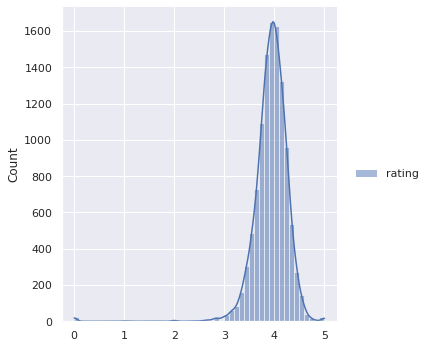

In [451]:
# Distribution of ratings
sns.displot(
    data=df_cleaned.select('rating').toPandas(),
    bins=50,
    kde=True)

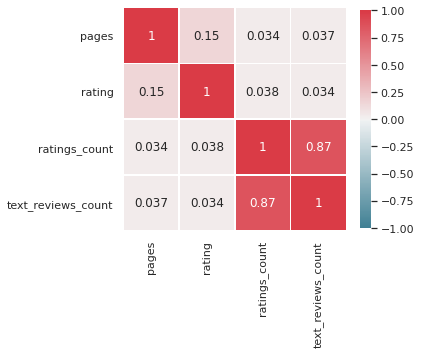

In [452]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    df_cleaned.select('pages','rating','ratings_count','text_reviews_count').toPandas().corr(), 
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0, 
    center=0, 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .8},
    annot=True
)

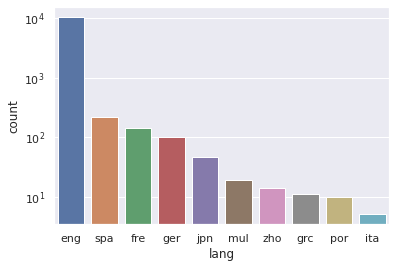

In [453]:
# Top 10 languages
sns.barplot(
    data=df_cleaned.groupby('lang').count().sort(desc("count")).limit(10).toPandas(),
    x='lang',
    y='count'
)
plt.yscale('log')

In [454]:
# Data on Neal Stephenson english books
df_cleaned.filter(df_cleaned.main_author.like("%Stephenson%") & df_cleaned.lang.like("%eng%")).sort(desc('rating')).show()

+------+--------------------+---------------+----+----------+-----+------+-------------+------------------+
|bookID|               title|    main_author|lang|  pub_date|pages|rating|ratings_count|text_reviews_count|
+------+--------------------+---------------+----+----------+-----+------+-------------+------------------+
|   822|The Confusion (Th...|Neal Stephenson| eng|2005-06-14|  815|  4.26|        19320|               565|
|   816|       Cryptonomicon|Neal Stephenson| eng|2002-11-01| 1139|  4.25|        83184|              4249|
|   829|Odalisque (The Ba...|Neal Stephenson| eng|2006-03-28|  464|   4.2|         1567|                65|
|   827|The Diamond Age: ...|Neal Stephenson| eng|2000-05-02|  499|  4.19|        71042|              2767|
|   830|          Snow Crash|Neal Stephenson| eng|2000-08-02|  438|  4.03|       188100|              6612|
| 45280|Quicksilver (The ...|Neal Stephenson| eng|2003-10-02|  927|  3.93|          171|                12|
|   823|Quicksilver (The ...

In [455]:
# Best rated authors
df_best_authors = df_cleaned.groupby('main_author').agg(
    avg('rating').alias('mean_rating'),
    max('rating').alias('max_rating'),
    count('rating').alias('number_of_books'),
    avg('ratings_count').alias('mean_rating_count'),
    sum('pages').alias('total_pages'),
    ).sort(desc('mean_rating'))
    
df_best_authors.show()

+--------------------+-----------------+----------+---------------+-----------------+-----------+
|         main_author|      mean_rating|max_rating|number_of_books|mean_rating_count|total_pages|
+--------------------+-----------------+----------+---------------+-----------------+-----------+
|        Dennis Adler|              5.0|       5.0|              1|              2.0|        372|
|   James E. Campbell|              5.0|       5.0|              1|              0.0|        314|
|       Keith Donohue|              5.0|       5.0|              1|              1.0|        222|
|  William C. Dowling|              5.0|       5.0|              1|              1.0|        179|
|        Ross Garnaut|              5.0|       5.0|              1|              1.0|        350|
| Sheri Rose Shepherd|              5.0|       5.0|              1|              2.0|        240|
|Middlesex Borough...|              5.0|       5.0|              1|              2.0|        128|
|      Chris    Gree

In [456]:
### Normalize columns "total_pages" and "mean_rating_count" to create a score based on rating and corrected by these 2 features

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in ["total_pages","mean_rating_count"]:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df_best_authors = pipeline.fit(df_best_authors).transform(df_best_authors).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

# Most popular authors
df_best_authors = df_best_authors.withColumn('score', col('total_pages_Scaled')*col('mean_rating_count_Scaled')*col('mean_rating')).sort(desc('score'))
df_best_authors.show(10)

+-------------------+------------------+----------+---------------+------------------+-----------+------------------+------------------------+--------------------+
|        main_author|       mean_rating|max_rating|number_of_books| mean_rating_count|total_pages|total_pages_Scaled|mean_rating_count_Scaled|               score|
+-------------------+------------------+----------+---------------+------------------+-----------+------------------+------------------------+--------------------+
|       J.K. Rowling|4.5212499896685285|      4.78|             24| 375245.3333333333|      16473|             0.478|                   0.082| 0.17721491459504765|
|     J.R.R. Tolkien| 4.223137303894641|      4.59|             51|109839.05882352941|      25518|             0.741|                   0.024|  0.0751042738124623|
|    Stephenie Meyer|3.5899999141693115|      3.59|              1|         4597666.0|        501|             0.015|                     1.0| 0.05384999871253967|
|          Dan B